##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example we show how to fit regression models using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [7]:
#@title Import { display-mode: "form" }


from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [8]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [9]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Well not only is it possible, but this colab shows how! (In context of linear regression problems.)

In [15]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [16]:
n_examples = y.shape[0]

In [17]:
expectednegloglik = lambda y, rv_y: -rv_y.log_prob(y)/n_examples

### Case 1: MLE Linear Regression with Constant Uncertainty

In [18]:
# Build model.
input = tf.keras.layers.Input(1)
linear = tf.keras.layers.Dense(1)(input)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(linear)
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.12854978
5.1231384


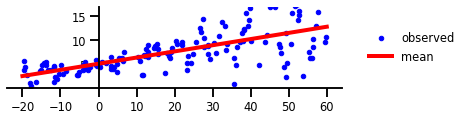

In [19]:

w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

### Case 2: MLE Linear Model with Homoscedastic Uncertainty

In [20]:
# Build model.
input = tf.keras.layers.Input(1)
linear = tf.keras.layers.Dense(1)(input)
s = tfp.layers.VariableLayer(shape=[1],activation=tf.keras.activations.exponential)(True)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([linear,s])
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13314469
5.126857


In [21]:
yhat.shape

TensorShape([150, 1])

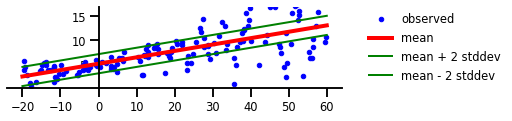

In [22]:

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 2: MLE Neural Network Regression with Heteroscedastic Uncertainty

In [27]:
# Build model.
input = tf.keras.layers.Input(1)
h1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.relu)(input)
m = tf.keras.layers.Dense(1)(h1)
s = tf.keras.layers.Dense(1,activation=tf.keras.activations.exponential)(h1)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([m,s])
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.22210978 -0.05285123  0.27132493 -0.43653685 -0.3874117  -0.12958677
 -0.4089895   0.19560549  0.15850185 -0.4116444 ]
[ 1.2610528   2.2336502   0.20482877 -0.25929427  1.5090367   0.93592495
  0.3678086  -0.2785634  -0.51358426 -0.22132489]
[ 1.2941326   0.21817122  0.39053163 -0.37364286  1.0653913  -0.83778274
  0.04332319 -0.6997085  -0.60402745 -0.509842  ]
1.9996469
[ 0.02329431 -0.2365324   0.2910628   0.07532969 -0.05295813 -0.59310114
  0.39926422 -0.0015304  -0.38257083  0.04452535]
0.32935056


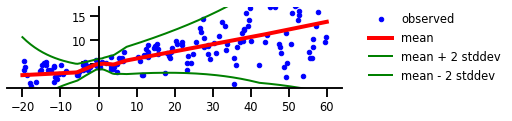

In [28]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 2: MAP Neural Network Regression with Heteroscedastic Uncertainty

In [29]:
l2_reg = tf.keras.regularizers.l2(l2=0.00001)
# Build model.
input = tf.keras.layers.Input(1)
h1 = tf.keras.layers.Dense(100,activation=tf.keras.activations.relu,kernel_regularizer=l2_reg,bias_regularizer=l2_reg)(input)
m = tf.keras.layers.Dense(1,kernel_regularizer=l2_reg,bias_regularizer=l2_reg)(h1)
s = tf.keras.layers.Dense(1,activation=tf.keras.activations.exponential,kernel_regularizer=l2_reg,bias_regularizer=l2_reg)(h1)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([m,s])
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-3.7108586e-04 -2.0799157e-03  3.5292208e-02 -9.1406189e-02
  8.6128727e-02  1.6743754e-01  2.3503611e-02  7.6697688e-09
 -3.2665358e-08 -1.5027208e-04 -8.2380980e-02 -1.2016506e-03
  2.5061323e-04 -4.2595595e-08 -3.2243662e-04 -3.4951558e-05
 -6.8986952e-02 -1.9726292e-03 -2.4820928e-04 -2.0538645e-03
 -3.6387870e-03 -7.7580777e-04 -2.4358779e-03 -1.8665043e-04
  6.6255480e-03 -2.7966764e-04  1.7960625e-02  1.4940076e-07
 -5.5524027e-03 -2.3366796e-05 -3.5992896e-06 -2.5545543e-03
  5.6686471e-03 -9.7552576e-05 -1.7180632e-01 -1.5408838e-04
 -6.9659226e-02  6.0915295e-03 -6.9708950e-10 -1.5528512e-04
 -7.4113063e-06 -5.4474291e-04  2.5097273e-02 -2.4252374e-06
  2.5831279e-09 -2.1684372e-03 -8.5332394e-02  6.5867499e-02
 -1.7690818e-05  4.5674641e-02  3.3336211e-02  4.1673847e-09
 -2.6008025e-02 -1.6444674e-03 -1.7188695e-05 -9.1296386e-07
  1.4757317e-03 -1.1191782e-02 -7.8006007e-05 -1.3117234e-01
 -6.0821383e-04 -2.6134852e-01 -9.6183387e-05 -2.2128548e-05
  1.8055759e-02 -1.23966

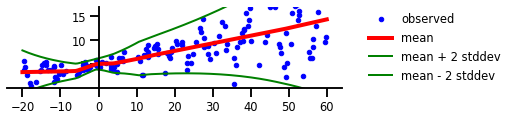

In [30]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)